In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torch import Tensor
from abc import ABC, abstractmethod
from torch.nn.functional import relu
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm
import scipy.stats as st
from diffusion_practice_params import get_derivative_log_pt_manual,p_t_calculate

import torch.nn.functional as F


## DATASET CREATION


(array([0.00126653, 0.        , 0.        , 0.00126652, 0.        ,
        0.00126652, 0.00253305, 0.        , 0.00126653, 0.00253304,
        0.00379958, 0.00126652, 0.00633263, 0.01139874, 0.00886566,
        0.00633263, 0.0113987 , 0.01266526, 0.02026436, 0.02786358,
        0.02533045, 0.03672926, 0.04179524, 0.04052884, 0.05699368,
        0.06079307, 0.07345841, 0.06459274, 0.08739017, 0.08992322,
        0.11018761, 0.12918567, 0.13425157, 0.19884431, 0.18997864,
        0.20644345, 0.23810656, 0.22417479, 0.25837095, 0.27990186,
        0.29763342, 0.28623448, 0.32169716, 0.37362465, 0.36095941,
        0.37362479, 0.41035385, 0.39135606, 0.37489121, 0.40275475,
        0.37489125, 0.39008954, 0.37362469, 0.34449459, 0.40782096,
        0.36349246, 0.36602551, 0.34829417, 0.31916411, 0.3115652 ,
        0.29636667, 0.26217052, 0.24950528, 0.21910869, 0.23937308,
        0.18997864, 0.18364601, 0.13805114, 0.1355183 , 0.12791895,
        0.12285285, 0.10765456, 0.10638804, 0.06

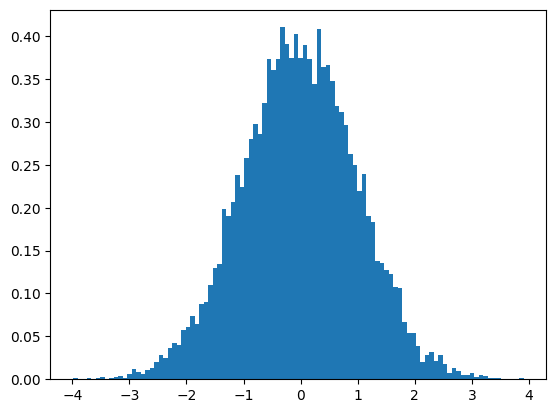

In [2]:
def manifold_func(x):
    return x**2

N_SAMPLES = 10000
x = torch.randn(size=(N_SAMPLES,))
x_data_global=x
y = manifold_func(x)
data = x#torch.stack([x,y],axis=1)
plt.hist(x,density=True,bins=100)

# fig, ax = plt.subplots()
# ax.scatter(data[:50,0],data[:50,1])
# ax.set_xlim(-2,2)
# ax.set_ylim(-2,2)

In [3]:
print(x_data_global.shape)

torch.Size([10000])


In [4]:
from torch.utils.data import Dataset, DataLoader
class ManifoldDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = data[idx]
        return data_item

dataset = ManifoldDataset(data)
batch_size = 4800
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Forward SDE

In [5]:
#PARAMS
x_R_global=10
sigma_global=1
lambda_poisson_global=0.1
alpha_global=beta_global=np.sqrt(2*lambda_poisson_global/(sigma_global*sigma_global))
print(alpha_global)
K_param_global=alpha_global*beta_global/(alpha_global+beta_global)


0.4472135954999579


In [6]:
def const_g(t,constant=sigma_global):
    return(t*0+constant)
def constant_f(x,t,const=0):

    return(x*0+const)

def counter_h(x_t,X_R=x_R_global):
    return(X_R-x_t)


In [7]:
#IMPORTANT FOR TESTING CODE
from diffusion_practice_params import f_LDP_func
# ob=SDE(constant_f,const_g,counter_h,lambda_poisson_global,x_R_global,alpha_global,beta_global,sigma_global)
# samplez=ob.sample_batch_from_LDP_numpy(10000)
# min_val = np.min(samplez)-10
# max_val = np.max(samplez)+5
# print(min_val,max_val)
# bins = np.linspace(min_val, max_val, 100) # 100 bins, or adjust as needed
# x_vals = np.linspace(np.min(samplez) -1 , np.max(samplez) + 1, 500)
# pdf_samples=f_LDP_func(torch.tensor(x_vals), torch.tensor(K_param_global), torch.tensor(alpha_global), torch.tensor(beta_global), torch.tensor(x_R_global), torch.float64)

# # plt.plot(x_vals, pdf_samples, 'r-', lw=2, label='Theoretical PDF')
# # Plot histogram for f_LDP
# # plt.hist(samplez, bins=bins, density=True, alpha=0.6)
# samplez2_conv=ob.sample_batch_from_convolution(torch.zeros(samplez.shape[0]))

# samplez3_pt=ob.sample_batch_from_p_t_given_x_0(0+torch.zeros(samplez.shape[0]),torch.zeros(samplez.shape[0])+1)
# # print(samplez3_pt.sum())
# sample4=ob.sample_batch_from_gaussian_mean_x0_plus_mut(torch.zeros(1),torch.zeros(samplez.shape[0])+0.01)   
# # plt.hist(samplez3_pt, bins=bins, density=True, alpha=0.6)
# # plt.hist(sample4, bins=bins, density=True, alpha=0.6)
# X_t_,_,score_=ob.run_forward(torch.zeros(5),torch.rand(5))
# ob.run_forward_random_times(torch.randn(5))


In [ ]:
class SDE:
    def __init__(self,f_determ_drift, g_random_drift,h_random_drift, 
        POISSON_LAMDA,X_R,ALPHA,BETA,SIGMA,
        t_start: float = 0.0, 
        t_end: float = 500.0, 
        n_steps: int = 10000,
        device='cuda:0'):

        self.f=f_determ_drift
        self.g=g_random_drift
        self.h=h_random_drift
        self.lamda=POISSON_LAMDA
        self.t_start=t_start
        self.t_end=t_end
        self.n_steps=n_steps
        self.X_R=X_R
        self.alpha=ALPHA 
        self.beta=BETA
        self.sigma=SIGMA
        self.device=device
        self.T_max=t_end

        
    def _mult_first_dim(self,t,X):
        """ 
        Helper function to multiply one-dimensional time vector with tensor of
        arbitrary shape.
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            has same shape as X_0 - inputs X_0[i] multipled with t[i]
        """
        return t.view(-1,*[1]*(X.dim()-1))*X
    def sample_batch_from_LDP_numpy(self, num_samples):  #CORRECT
        """
        Generates a batch of samples from the LDP distribution using NumPy for vectorization.
        (Assumes x_R, alpha, beta are scalars, num_samples is an int)
        """
        x_R=self.X_R
        alpha=self.alpha
        beta=self.beta
        if alpha <= 0 or beta <= 0:
            raise ValueError("alpha and beta must be positive.")
        if num_samples <= 0:
            raise ValueError("num_samples must be positive.")

        p_left = alpha / (alpha + beta)
        u1_array = np.random.rand(num_samples)
        u2_array = np.random.rand(num_samples)
        u2_array[u2_array == 0.0] = np.finfo(float).eps # Avoid log(0)

        log_u2_array = np.log(u2_array)
        samples = np.empty(num_samples)
        is_left_tail = u1_array <= p_left

        samples[is_left_tail] = x_R + log_u2_array[is_left_tail] / beta
        is_right_tail = ~is_left_tail
        samples[is_right_tail] = x_R - log_u2_array[is_right_tail] / alpha
            
        return samples
    # --- End of LDP sampler ---

    def sample_batch_from_convolution(self,   #CORRECT
                                     t_fN  
):
        """
        Generates a batch of samples from the convolution f_N * f_LDP.

        Args:
            num_samples (int): The number of samples to generate.
            mu_fN (float): Parameter μ for the Normal distribution f_N.
            t_fN (float): Parameter t for the Normal distribution f_N. Must be > 0.
            sigma_fN (float): Parameter σ for the Normal distribution f_N. Must be > 0.
            x_R_LDP (float): Parameter x_R for the LDP distribution.
            alpha_LDP (float): Parameter α for the LDP distribution. Must be > 0.
            beta_LDP (float): Parameter β for the LDP distribution. Must be > 0.

        Returns:
            numpy.ndarray: An array of `num_samples` from the convolved distribution.
        """
        # if t_fN <= 0:
        #     raise ValueError("t_fN (for Normal distribution) must be positive.")
        # if sigma_fN <= 0:
        #     raise ValueError("sigma_fN (for Normal distribution) must be positive.")

        # 1. Sample from f_N (Normal distribution)
        mu_fN=0

        mean_N = mu_fN * t_fN
        sigma_fN=self.sigma
        std_dev_N = sigma_fN * np.sqrt(t_fN)
        
        x_R_LDP=self.X_R
        alpha_LDP=self.alpha
        beta_LDP=self.beta
        # num_samples=t_fN.shape[0]
        samples_N = np.random.normal(loc=mean_N, scale=std_dev_N)

        # 2. Sample from f_LDP
        samples_LDP = self.sample_batch_from_LDP_numpy( t_fN.shape[0])

        # 3. The convolved sample is the sum of the independent samples
        convolved_samples = samples_N + samples_LDP
        
        return convolved_samples
    
    def sample_batch_from_gaussian_mean_x0_plus_mut(self,x_0,t): #F_w IN NOTES   CORRECT
        mean_N = 0 * t + x_0
        std_dev_N = self.sigma * np.sqrt(t)
        samples_W = np.random.normal(loc=mean_N, scale=std_dev_N)
        return samples_W

    def sample_batch_from_p_t_given_x_0(self,x_0,t):   #CORRECT
        mask=np.random.binomial(n=1, p=np.exp(-1*self.lamda*t))
        sample=mask*self.sample_batch_from_gaussian_mean_x0_plus_mut(x_0,t)+(1-mask)*self.sample_batch_from_convolution(t)

        return(sample)





    def run_forward_slow(self,x): #BATCH OF INITIAL DATA AND TIME STEPS 
        
        #Number of trajectories, dimension of data:
        n_traj,dim_x = x.shape
        time_grid = np.linspace(self.t_start,self.t_end,self.n_steps)
        step_size = time_grid[1]-time_grid[0]

        jump_occurred = np.random.poisson(lam=self.lamda*step_size, size=(self.n_steps,n_traj))>0
        jump_occurred=(torch.tensor(jump_occurred).unsqueeze(2)).numpy()

        random_drift_grid = self.g(time_grid)

        noise = np.random.normal(size=(self.n_steps,n_traj,dim_x))
        random_drift_grid_sample = np.sqrt(step_size)*random_drift_grid[:,None,None]*noise

        #Initialize list of trajectory:
        x_traj = [x]

    
    
        for idx,time in tqdm(enumerate(time_grid)):
            
            #Get last location and time
            x = x_traj[idx]
            t = float(time_grid[idx])
            
            #Get deterministic drift and random drift sample
            determ_drift = step_size*self.f(x,t)
            random_drift_sample = random_drift_grid_sample[idx]
            poisson_drift=self.h(x)*jump_occurred[idx].astype(np.float32)
            
            #Compute next step:
            next_step = x + determ_drift + random_drift_sample + poisson_drift
            
            #Save step:
            x_traj.append(next_step)

        return np.stack(x_traj),time_grid   
    
    def run_forward(self, X_0: Tensor, t: Tensor, clip_factor: float = 0.01):  #correct
        """
        Function to evolve SDE forward in time from 0 to t<=self.T_max.
        Assume that conditional distribution is Gaussian
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            X_t: shape as X_0 - noised input
            noise: shape as X_0 - noise converting X_0 to X_t
            score: shape as X_0 - score of conditional distribution q_t|0(X_t|X_0)
        """
        noise = 0
        X_t=self.sample_batch_from_p_t_given_x_0(X_0,t)
        score=get_derivative_log_pt_manual( X_t,X_0,0,self.sigma,self.lamda,self.X_R,t,self.device,torch.float64,False)
        




        return X_t, noise, score
    
    def score(self,X_t,X_0,t,gt):
        return(get_derivative_log_pt_manual( X_t,X_0,0,self.sigma,self.lamda,self.X_R,t,self.device,torch.float64,gt))

        
    def run_forward_random_times(self, X_0: Tensor): #correct
        """Function to evolve SDE forward until random times."""
        t = self.sample_random_times(X_0.shape[0])
        X_t, noise, score = self.run_forward(X_0,t)
        return X_t, noise, score, t

    def sample_random_times(self, length: int): #correct
        """Sample 'length' time points uniformly in interval [0,T]"""
        return torch.rand(size=(length,))*self.T_max
    def calculate_p_t(self,x,X_0,t):
        K_s=self.alpha*self.beta/(self.alpha+self.beta)
        p_t_val=p_t_calculate(x, X_0, 0*self.sigma, self.sigma, self.lamda, t, self.X_R, K_s, self.alpha, self.beta,
                  5, 1000, self.device, torch.float64,False)
        return p_t_val


        
    


In [9]:
ob=SDE(constant_f,const_g,counter_h,lambda_poisson_global,x_R_global,alpha_global,beta_global,sigma_global)
x_vals = torch.tensor(np.linspace(-10 , 40, 500)).cuda()
id=200
x_traj,time_grid=ob.run_forward_slow(x.unsqueeze(1))
# pdf_x_vals=ob.calculate_p_t(x_vals,x_vals*0,time_grid[id]+x_vals*0)


0it [00:00, ?it/s]

In [10]:
time_grid.shape

(10000,)

In [11]:
time_grid[200]
x_traj.shape

(10001, 10000, 1)

In [12]:
# pdf_x_vals.shape

(10001, 10000, 1)


(array([0.00069853, 0.00069853, 0.00069853, 0.00069853, 0.00069853,
        0.00104779, 0.00104779, 0.00069853, 0.00174632, 0.00244485,
        0.00349265, 0.00244485, 0.00349265, 0.00698529, 0.0059375 ,
        0.00733456, 0.01222426, 0.01292279, 0.01327206, 0.0167647 ,
        0.01606617, 0.01641544, 0.02444852, 0.02095588, 0.02340073,
        0.02444852, 0.02933823, 0.03422793, 0.0286397 , 0.03283087,
        0.03841911, 0.04121323, 0.03422793, 0.0394669 , 0.04610293,
        0.03806984, 0.04784925, 0.04610293, 0.04575367, 0.04924631,
        0.04191176, 0.03806984, 0.04610293, 0.0405147 , 0.03492646,
        0.03248161, 0.03318014, 0.02549632, 0.02724264, 0.02444852,
        0.02165441, 0.02409926, 0.02374999, 0.01920955, 0.02235294,
        0.02095588, 0.02374999, 0.02130514, 0.02933823, 0.02340073,
        0.03178308, 0.03597426, 0.03562499, 0.0562316 , 0.05553308,
        0.06181984, 0.07648895, 0.08801469, 0.10582718, 0.14005511,
        0.14494482, 0.17148893, 0.17742643, 0.14

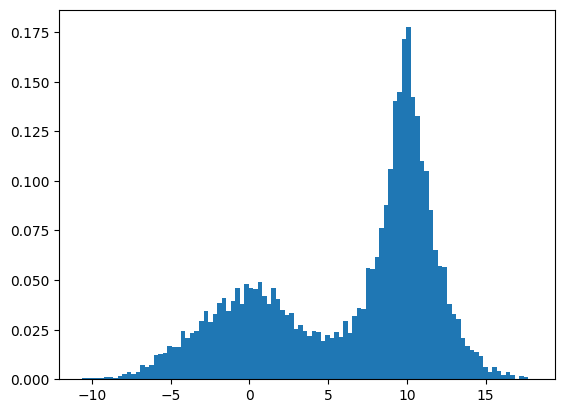

In [13]:
print(x_traj.shape)
plt.hist(x_traj[id,:,0],bins=100,density=True)
# plt.plot(x_vals.cpu(),pdf_x_vals.cpu())

In [14]:
# P_lambda=10
# ob=SDE(constant_f,const_g,counter_h,lambda_poisson_global,x_R_global,alpha_global,beta_global,sigma_global)

# x_start=dataset.data
# x_traj,time_grid = ob.run_forward_slow (x_start)

# x_traj.shape,time_grid.shape

In [15]:

# x_traj.shape,time_grid.shape  #1000 times movement euler move occured

In [16]:
#HIGHER DIMS
# def sample_batch_from_LDP_numpy(x_R, alpha, beta, num_samples):
#     if alpha <= 0 or beta <= 0:
#         raise ValueError("alpha and beta must be positive.")
#     if num_samples <= 0:
#         raise ValueError("num_samples must be positive.")
#     p_left = alpha / (alpha + beta)
#     u1_array = np.random.rand(num_samples)
#     u2_array = np.random.rand(num_samples)
#     u2_array[u2_array == 0.0] = np.finfo(float).eps
#     log_u2_array = np.log(u2_array)
#     samples = np.empty(num_samples)
#     is_left_tail = u1_array <= p_left
#     samples[is_left_tail] = x_R + log_u2_array[is_left_tail] / beta
#     is_right_tail = ~is_left_tail
#     samples[is_right_tail] = x_R - log_u2_array[is_right_tail] / alpha
#     return samples

In [17]:
# import torch
# import numpy as np
# def sample_batch_from_convolution_GaussXLDP( 
#                                   mu_fN, t_fN, sigma_fN, 
#                                   x_R_LDP, alpha_LDP, beta_LDP):
#     # if t_fN <= 0:
#     #     raise ValueError("t_fN (for Normal distribution) must be positive.")
#     # if sigma_fN <= 0:
#     #     raise ValueError("sigma_fN (for Normal distribution) must be positive.")
#     t_fN=t_fN.reshape(-1,1)
#     mu_fN=mu_fN.reshape(1,-1)
#     sigma_fN=sigma_fN.reshape(1,-1)
#     # x_0=x_0.reshape(1,-1)
#     mean_N = (mu_fN * t_fN)
#     # print(mean_N)
#     std_dev_N = sigma_fN * np.sqrt(t_fN)
#     # print(std_dev_N)

#     samples_N = np.random.normal(loc=mean_N.reshape(-1), scale=std_dev_N.reshape(-1), size=(1,mean_N.shape[0]*mean_N.shape[1]))
#     samples_N=samples_N.reshape(mean_N.shape)
#     # print(samples_N)
#     samples_LDP_component = sample_batch_from_LDP_numpy(x_R_LDP, alpha_LDP, beta_LDP, samples_N.shape[0]*samples_N.shape[1]).reshape(samples_N.shape)
#     print(samples_N.shape,samples_LDP_component.shape)
#     convolved_samples = samples_N + samples_LDP_component
#     return convolved_samples

# def sample_batch_from_Gaussian_G(mu_fN, t_fN, sigma_fN,x_0):
#     t_fN=t_fN.reshape(-1,1)
#     mu_fN=mu_fN.reshape(1,-1)
#     sigma_fN=sigma_fN.reshape(1,-1)
#     x_0=x_0.reshape(1,-1)
#     mean_N = (mu_fN * t_fN)+x_0
#     # print(mean_N)
#     std_dev_N = sigma_fN * np.sqrt(t_fN)
#     # print(std_dev_N)

#     samples_N = np.random.normal(loc=mean_N.reshape(-1), scale=std_dev_N.reshape(-1), size=(1,mean_N.shape[0]*mean_N.shape[1]))
#     # print(samples_N.shape)
#     samples_N=samples_N.reshape(mean_N.shape)
#     return samples_N










# mu_fN=np.array([0.0,10.0])
# sigma_fN=np.array([0.1,0.1])
# t_fN=np.array([1,5,10])
# x_0=np.array([3.0,6.0])
# x_R_LDP=5
# alpha_LDP=1
# beta_LDP=1

# # sample_batch_from_Gaussian_G(mu_fN,t_fN,sigma_fN,x_0)
# sample_batch_from_convolution_GaussXLDP( mu_fN, t_fN, sigma_fN, x_R_LDP, alpha_LDP, beta_LDP)

In [18]:
# mu_fN=np.array([0,10]).reshape(1,2)
# t_fN=np.array([1,2,3]).reshape(3,1)
# all=mu_fN*t_fN
# all


In [19]:
# time_steps = list(range(0, x_traj.shape[0], 100))

# # Create subplots (you can adjust layout based on number of plots)
# n_plots = len(time_steps)
# n_cols = 4
# n_rows = -(-n_plots // n_cols)  # Ceiling division

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
# axes = axes.flatten()  # Flatten in case it's 2D

# for i, t in enumerate(time_steps):
#     ax = axes[i]
#     ax.scatter(x_traj[t, :, 0], x_traj[t, :, 1], s=5)
#     ax.set_title(f"t={t}s")
#     ax.set_xlabel("Dim 1")
#     ax.set_ylabel("Dim 2")
#     ax.grid(True)
#     ax.set_xlim(0, 4)
#     ax.set_ylim(0, 4)

# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# fig.tight_layout()
# plt.show()

## Training

In [20]:
# model=FullConnectedScoreModel()
# model(torch.zeros(3,1),torch.zeros(3))

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt
# import math # Only for the single LDP sampler if used directly, not strictly needed here

# # --- Re-include the LDP batch sampler ---
# def sample_batch_from_LDP_numpy(x_R, alpha, beta, num_samples):
#     if alpha <= 0 or beta <= 0:
#         raise ValueError("alpha and beta must be positive.")
#     if num_samples <= 0:
#         raise ValueError("num_samples must be positive.")
#     p_left = alpha / (alpha + beta)
#     u1_array = np.random.rand(num_samples)
#     u2_array = np.random.rand(num_samples)
#     u2_array[u2_array == 0.0] = np.finfo(float).eps
#     log_u2_array = np.log(u2_array)
#     samples = np.empty(num_samples)
#     is_left_tail = u1_array <= p_left
#     samples[is_left_tail] = x_R + log_u2_array[is_left_tail] / beta
#     is_right_tail = ~is_left_tail
#     samples[is_right_tail] = x_R - log_u2_array[is_right_tail] / alpha
#     return samples

# # --- Re-include the convolution batch sampler ---
# def sample_batch_from_convolution(num_samples, 
#                                   mu_fN, t_fN, sigma_fN, 
#                                   x_R_LDP, alpha_LDP, beta_LDP):
#     if t_fN <= 0:
#         raise ValueError("t_fN (for Normal distribution) must be positive.")
#     if sigma_fN <= 0:
#         raise ValueError("sigma_fN (for Normal distribution) must be positive.")
#     mean_N = mu_fN * t_fN
#     std_dev_N = sigma_fN * np.sqrt(t_fN)
#     samples_N = np.random.normal(loc=mean_N, scale=std_dev_N, size=num_samples)
#     samples_LDP_component = sample_batch_from_LDP_numpy(x_R_LDP, alpha_LDP, beta_LDP, num_samples)
#     convolved_samples = samples_N + samples_LDP_component
#     return convolved_samples

# # --- Main plotting script ---
# if __name__ == '__main__':
#     # Define common parameters
#     batch_size = 20000 # Use a larger batch size for smoother histograms

#     # Parameters for f_LDP (will be used for both direct sampling and as part of convolution)
#     param_x_R_LDP = 2.0
#     param_alpha_LDP = 2.0  # Controls right tail decay
#     param_beta_LDP = 1.0   # Controls left tail decay

#     # Parameters for f_N (the Normal distribution to convolve with f_LDP)
#     # Let's try a few scenarios for f_N to see its effect
    
#     # Scenario 1: Narrow Normal distribution (small smoothing effect)
#     param_mu_fN_1 = 0
#     param_t_fN_1 = 0.8
#     param_sigma_fN_1 = 0.2  # Results in std_dev_N = 0.2 * sqrt(1) = 0.2

#     # Scenario 2: Wider Normal distribution (larger smoothing effect)
#     param_mu_fN_2 = 0.5 # Introduce a slight shift as well
#     param_t_fN_2 = 1.0
#     param_sigma_fN_2 = 1.0  # Results in std_dev_N = 1.0 * sqrt(1) = 1.0

#     # --- Generate samples ---

#     # 1. Samples from f_LDP directly
#     samples_ldp_direct = sample_batch_from_LDP_numpy(
#         param_x_R_LDP, param_alpha_LDP, param_beta_LDP, batch_size
#     )

#     # 2. Samples from convolution (Scenario 1)
#     samples_convolved_1 = sample_batch_from_convolution(
#         num_samples=batch_size,
#         mu_fN=param_mu_fN_1, t_fN=param_t_fN_1, sigma_fN=param_sigma_fN_1,
#         x_R_LDP=param_x_R_LDP, alpha_LDP=param_alpha_LDP, beta_LDP=param_beta_LDP
#     )
    
#     # 3. Samples from convolution (Scenario 2)
#     samples_convolved_2 = sample_batch_from_convolution(
#         num_samples=batch_size,
#         mu_fN=param_mu_fN_2, t_fN=param_t_fN_2, sigma_fN=param_sigma_fN_2,
#         x_R_LDP=param_x_R_LDP, alpha_LDP=param_alpha_LDP, beta_LDP=param_beta_LDP
#     )

#     # --- Plotting ---
#     plt.figure(figsize=(12, 7))
    
#     # Determine common bin range for all histograms for better comparison
#     all_samples = np.concatenate([samples_ldp_direct, samples_convolved_1, samples_convolved_2])
#     min_val = np.min(all_samples)
#     max_val = np.max(all_samples)
#     bins = np.linspace(min_val, max_val, 100) # 100 bins, or adjust as needed

#     # Plot histogram for f_LDP
#     plt.hist(samples_ldp_direct, bins=bins, density=True, alpha=0.6, 
#              label=f'$f_{{LDP}}(x)$ (x_R={param_x_R_LDP}, α={param_alpha_LDP}, β={param_beta_LDP})')

#     # Plot histogram for convolution Scenario 1
#     label_conv1 = (f'$f_N * f_{{LDP}}$ (Normal: μt={param_mu_fN_1*param_t_fN_1:.1f}, '
#                    f'σ√t={param_sigma_fN_1*np.sqrt(param_t_fN_1):.1f})')
#     plt.hist(samples_convolved_1, bins=bins, density=True, alpha=0.6, 
#              label=label_conv1)

#     # Plot histogram for convolution Scenario 2
#     # label_conv2 = (f'$f_N * f_{{LDP}}$ (Normal: μt={param_mu_fN_2*param_t_fN_2:.1f}, '
#     #                f'σ√t={param_sigma_fN_2*np.sqrt(param_t_fN_2):.1f})')
#     # plt.hist(samples_convolved_2, bins=bins, density=True, alpha=0.6, 
#     #          label=label_conv2)
    
#     plt.title('Comparison of $f_{LDP}$ and Convolved Distributions ($f_N * f_{LDP}$)')
#     plt.xlabel('Value (x)')
#     plt.ylabel('Density')
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.show()

#     # Print some statistics for context
#     print(f"--- Statistics for f_LDP (direct) ---")
#     print(f"Mean: {np.mean(samples_ldp_direct):.3f}, Std Dev: {np.std(samples_ldp_direct):.3f}")
    
#     mean_N1 = param_mu_fN_1 * param_t_fN_1
#     std_N1 = param_sigma_fN_1 * np.sqrt(param_t_fN_1)
#     print(f"\n--- Statistics for Convolution (Scenario 1: Normal(mean={mean_N1:.2f}, std={std_N1:.2f})) ---")
#     print(f"Mean: {np.mean(samples_convolved_1):.3f}, Std Dev: {np.std(samples_convolved_1):.3f}")
    
#     mean_N2 = param_mu_fN_2 * param_t_fN_2
#     std_N2 = param_sigma_fN_2 * np.sqrt(param_t_fN_2)
#     print(f"\n--- Statistics for Convolution (Scenario 2: Normal(mean={mean_N2:.2f}, std={std_N2:.2f})) ---")
#     print(f"Mean: {np.mean(samples_convolved_2):.3f}, Std Dev: {np.std(samples_convolved_2):.3f}")

#     # Expected means reminder:
#     # Mean of LDP = x_R + (1/β) - (1/α)
#     expected_mean_LDP = param_x_R_LDP + (1/param_beta_LDP) - (1/param_alpha_LDP)
#     print(f"\nExpected mean of LDP: {expected_mean_LDP:.3f}")
#     print(f"Expected mean of Conv1: {expected_mean_LDP + mean_N1:.3f}")
#     print(f"Expected mean of Conv2: {expected_mean_LDP + mean_N2:.3f}")

In [22]:
class FullConnectedScoreModel(nn.Module):
    def __init__(self, data_dim: int = 1, hidden_dim: int = 128, n_hidden_layers: int = 2):
        super(FullConnectedScoreModel, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(data_dim+1, hidden_dim)
        self.input_batch_norm = nn.BatchNorm1d(hidden_dim)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            batch_norm = nn.BatchNorm1d(hidden_dim)
            self.hidden_layers.append(nn.Sequential(layer, batch_norm))

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, data_dim)  # Assuming output is a single value

    def forward(self, x, t):
        # print("net",x.shape,t.shape)
        x_conc_t = torch.concat([x,t.unsqueeze(1)],axis=1)
        x = F.relu(self.input_batch_norm(self.input_layer(x_conc_t)))

        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))

        return self.output_layer(x)

In [ ]:
def train_diffusion_model(model, sde, dataloader, optimizer, device, n_epochs, print_every):
    model.train()
    model = model.to(device)
    loss_function = nn.MSELoss(reduction='mean')
    running_loss_list = []
    
    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.0
        for idx, x_inp in enumerate(dataloader):
            
            #Zero gradients:
            optimizer.zero_grad()
            
            #Run forward samples:
            # X_t,noise,score,time = sde.run_forward_random_times(x_inp)
            # torch.arange(time_grid.shape[0])
            # print(time_grid.shape,x_traj.shape)
            indices = torch.randperm(time_grid.shape[0])[:batch_size]
            indices2=torch.randperm(x_traj.shape[1])[:batch_size]
            time=time_grid[indices]
            X_t=x_traj[indices,indices2]
            # print("main",X_t.shape,time.shape,x_data_global.shape)
            score=ob.score(X_t.squeeze(1),x_data_global[indices2],time,False)
            # print(score.shape)
            # print(time)
            score=torch.tensor(score).float()

            #Send to device:
            X_t = torch.tensor(X_t).to(device).float()
            # print("beofer training",X_t.shape)
            noise = None#torch.tensor(noise).to(device)
            time = torch.tensor(time).to(device).float()
            
            #Predict score:
            model_pred = model(X_t,time)
            # print("score",score.shape,model_pred.shape)

            #Compute loss:
            # print(score.shape,model_pred.shape)
            
            loss = loss_function(score,model_pred.squeeze(1))
            print("loss-",loss)
      

            #Optimize:
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.detach().item()
            
            if (idx+1) % print_every == 0:
                avg_loss = running_loss/print_every
                running_loss_list.append(avg_loss)
                running_loss = 0.0
                print(avg_loss)
    return model,running_loss_list
ob=SDE(constant_f,const_g,counter_h,lambda_poisson_global,x_R_global,alpha_global,beta_global,sigma_global)
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
N_EPOCHS = 1600
model=FullConnectedScoreModel()
model.train()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
device = "cuda" if torch.cuda.is_available() else "cpu"


model,running_loss_list = train_diffusion_model(model, ob, trainloader, optimizer, device=device, n_epochs=N_EPOCHS, print_every=10)


Epoch: 0


C:\Users\adity\AppData\Local\Temp\ipykernel_1144\2821268081.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score=torch.tensor(score).float()


loss- tensor(0.3018, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.3256, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.1462, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 1
loss- tensor(0.1130, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.1262, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.1152, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 2
loss- tensor(0.0973, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.0987, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.1056, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 3
loss- tensor(0.0873, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.0831, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.0829, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch: 4
loss- tensor(0.0898, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.0687, device='cuda:0', grad_fn=<MseLossBackward0>)
loss- tensor(0.0701, device='cuda:0', gr

In [ ]:
# from diffusion_practice_params import p_t_calculate,get_alpha_beta_K

In [ ]:
def run_backwards(model, sde, x_start, device, train_score, n_steps: int = 10, plot_evolution: bool = True, clip_max: float = 1.0, clip_min: float = -1.0, **kwargs):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    model = model.to(device)
    
    #Number of trajectories, dimension of data:
    n_traj = x_start.shape[0]
    ndim = x_start.dim()-1

    #Compute time grid for discretization and step size:
    time_grid = torch.linspace(sde.T_max,0,n_steps)
    step_size =torch.abs(time_grid[0]-time_grid[1])

    #Compute the random drift at every time point:
    random_drift_grid = sde.g(time_grid)
    
    #Sample random drift at every time point:
    noise = torch.randn(size=(n_steps,*list(x_start.shape)))
    random_drift_grid_sample = torch.sqrt(step_size) * noise * random_drift_grid.view(-1,*[1]*(ndim+1))
    
    #Initialize list of trajectory:
    x_traj = [x_start.unsqueeze(1)]

    # if plot_evolution:
    #     fig, axs = plt.subplots(1,len(time_grid),figsize=(6*len(time_grid),6))

    
    for idx,time in tqdm(enumerate(time_grid)):
        
        #Get last location and time
        x = x_traj[idx]
        t = time_grid[idx]
        time_vec = t.repeat(n_traj)
        
        #Deterministic drift: f(X_,t)
        determ_drift = step_size*sde.f(x,time_vec)

        #Get random drift:
        random_drift_sample = random_drift_grid_sample[idx].unsqueeze(1)

        #Get noise estimates:
        print("hello",x.shape,time_vec.shape)
        # model_estimate = model(x.to(device),time_vec.to(device)).detach().cpu()
        model_estimate=sde.score(x,x*0,t,True)
        print(model_estimate.shape)

        if train_score:
            score_estimates = model_estimate
        else:
            denominator = torch.clip(sde.cond_std(None, time_vec),0.01)
            if len(model_estimate.shape) == 4:
                score_estimates = -model_estimate/denominator[:,None,None,None]
            else:
                score_estimates = -model_estimate/denominator[:,None]

        #Correction term: g^2 * score estimate
        g_squared = (random_drift_grid[idx]**2).repeat(n_traj)
        correction_term = (step_size*sde._mult_first_dim(g_squared,score_estimates))
        # print(correction_term,random_drift_sample.shape)
        #Compute next step:
        change = (correction_term - determ_drift) + random_drift_sample
        print("change",change[0])
        
        next_step = x + change

        
        #Save step:
        x_traj.append(next_step)


            
    output = torch.stack(x_traj) #.transpose(1,0)
    #output = torch.clip(output, clip_min, clip_max)
    return output,time_grid    

In [ ]:
x_start = torch.tensor(ob.sample_batch_from_LDP_numpy( 1000)).float()
print(x_start.shape)
output,time_grid = run_backwards(model,ob,x_start=x_start,n_steps=10000,device=device, train_score=True)

torch.Size([1000])


0it [00:00, ?it/s]

hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([0.0421])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([0.3067])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([0.1984])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([-0.2452])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([0.4123])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([-0.0388])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([0.0265])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([0.0410])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([0.0166])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])
change tensor([0.0030])
hello torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000, 1])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

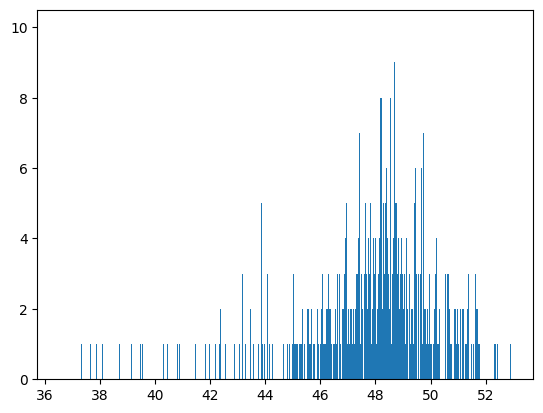

In [ ]:
plt.hist(output[10000,:,0],bins=1000)
# plt.hist(x_start,bins=1000)